# Feature Engineering

**Environment Setup**

In [1]:
#Loading key libraries for later analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
pd.set_option('max_colwidth', 1000)
!pip install spacy
!pip install xgboost
import sklearn   
import os
import functions
from statsmodels.tsa.stattools import kpss


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.       

In [2]:
#Read in bank transactions
df = pd.read_csv(r'final_df_full.csv',low_memory=False,encoding='latin1')

In [17]:
#External resources
currency = pd.read_csv(r'currency.csv',low_memory=False,encoding='latin1')
directors = pd.read_csv(r'director names.csv',low_memory=False,encoding='latin1')
financing = pd.read_csv(r'financing firms.csv',low_memory=False,encoding='latin1')

In [4]:
import os
os.getcwd()

'/project'

## 1. Numerical Feature Extraction

#### Week of month

In [18]:
#change date to datetime form for further analysis
df['date'] = pd.to_datetime(df['date'])
#get the dates of the date column
df['date_only'] = df['date'].dt.day

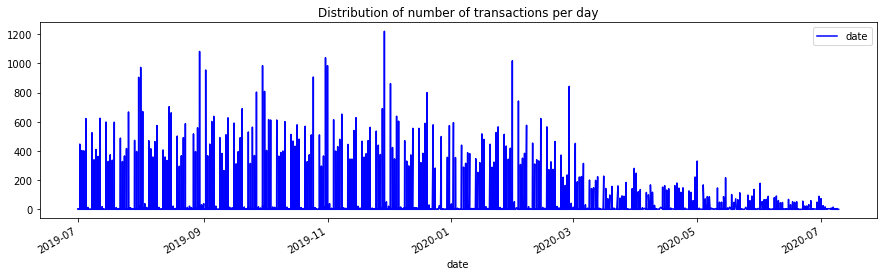

In [20]:
#count the number of transactions per day
trans_counts = df['date'].groupby(df['date']).count()

#plot the graph to show frequency features 
def frequency(timeseries):
    plt.figure(figsize=(15,4))
    timeseries.plot(color='blue')
    plt.legend(loc='best')
    plt.title('Distribution of number of transactions per day')
    plt.show()

frequency(trans_counts)

In [21]:
#create week of month variables
df['week_of_month'] = df['date_only'].apply(lambda x: 1 if x <8 else x)
df['week_of_month'] = df['week_of_month'].apply(lambda x: 2 if 8<= x <16 else x)
df['week_of_month'] = df['week_of_month'].apply(lambda x: 3 if 16<= x <25 else x)
df['week_of_month'] = df['week_of_month'].apply(lambda x: 4 if  x >=25 else x)

In [22]:
#check the number of transactions in each week 
df['week_of_month'].value_counts()

3    32067
1    29876
2    27970
4    27137
Name: week_of_month, dtype: int64

In [23]:
#generate dummy variables
df = df.join(pd.get_dummies(df['week_of_month'],prefix='week_of_month', prefix_sep='_', drop_first=True))

**Features extracted from transaction descriptions**

In [25]:
#Generate binary variables showing transactions containing foreign currencies and financing firm names
def feature_foreign_currency(df1,df2,column):
    functions.lowercase(df1,'code')
    functions.lowercase(df1,'currency')
    # Drop British Pounds
    df1 = df1.drop(df1[df1['code'] == 'gbp'].index)
    # Drop currencies that are no longer using
    df1 = df1.drop(df1[df1['currency'].str.contains(r'\(\d', regex=True)].index)
    # Remove the brackets
    df1['currency'] = df1['currency'].str.split('\(').str[0].str.strip()
    #Form the regex patterns
    df1['code'] = df1['code'].replace({r'(^.+)+( \w*$)': r'\d+(\.\d*)? ?(\1)? ?\2(s)?\\b'}, regex=True)
    # Match the regex expressions
    df1['code'] = r'(\d+(\.\d*)? ?| )' + df1['code'] + r'\b'
    # Rplace the currency code and name by 'currency'
    regex = '|'.join(df1['currency'])
    regex = '|'.join(df1['code']) + regex
    df2[column] = df2[column].replace(regex, ' currency ', regex=True)
    return 'finished'

def feature_financing_firms(df1,df2,column):
    functions.lowercase(df1,'name')
    #Form the regex patterns
    df1['name'] = r'\b' + df1['name'] + r'\W'
    # Replace the names by 'director'
    regex = '|'.join(df1['name'])
    df2[column] = df2[column].replace(regex, ' financing firm ', regex=True)
    return 'finished'


feature_foreign_currency(currency,df,'description')
feature_financing_firms(financing,df,'description')

'finished'

In [26]:
#Generate numerical features when transaction containaing certain numbers
#Bank Account number
def feature_bank_acc_no(df1,column):
    return df1[column].str.replace(r'\b(\d{6})( |)(\d{8})\W',' account ',regex=True)

#HMRC vat tax number
def feature_hmrc_vat(df1,column):
    return df1[column].str.replace(r'\b(vat|vat |vat  |\s|000|vat 000|vat  000|)\d{9}\W',' vat ',regex=True)

#HMRC corporation tax number
def feature_hmrc_corp(df1,column):
    return df1[column].str.replace(r'((cumb|cumb |cumbernauld |cumbernauld|ship|ship |shipley|shipley |cumb  |cumbernauld  |ship  |shipley  | )(?=.{3}[a-z]{2})(?=.*\d{12})(?=.{0}\d{3})?([a-z\d]{17}))((?=.{3}([a-z]{2}))(?=.*\d{12})(?=\d{3})[a-z\d]{17})|((cumb|cumb |cumbernauld |cumbernauld|ship|ship |shipley|shipley |cumb  |cumbernauld  |ship  |shipley  | )[a-z\d]{17})\W',' corporate tax ',regex=True)

#HMRC Paye number
def feature_hmrc_paye(df1,column):
    return df1[column].str.replace(r'\b(cumb|cumbernauld|cumb |cumbernauld |cumb  |cumbernauld  | )(?=.{3}[a-z]{2})(?=.*\d{8})(?=.{0}\d{3})[a-z\d]{13}\W',' paye ',regex=True)

#Extract number features 
def feature_number_combine(df1,column):
    df1[column] = feature_bank_acc_no(df1,column)
    df1[column] = feature_hmrc_vat(df1,column)
    df1[column] = feature_hmrc_corp(df1,column)
    df1[column] = feature_hmrc_paye(df1,column)
    return 'finished'

feature_number_combine(df,'description')

'finished'

In [27]:
#create binary features

df['foreign_binary'] = df['description'].str.contains('currency', regex=False).astype('int')
df['financing_binary'] = df['description'].str.contains('financing firm', regex=False).astype('int')
df['account_binary'] = df['description'].str.contains('account', regex=False).astype('int')
df['hmrc_vat'] = df['description'].str.contains('vat', regex=False).astype('int')
df['hmrc_corp'] = df['description'].str.contains('corporate tax', regex=False).astype('int')
df['hmrc_paye'] = df['description'].str.contains('paye', regex=False).astype('int')

In [29]:
#export dataframe for the second experiment: comparing the rate of performance of rule based and machine learning systems
df.to_csv(r'df_postfeat_time_series_FINAL.csv',index = False)

In [31]:
#export dataframe for the first experiment: classifying bank transactions 
df_ = functions.drop_column(df,'local_rule_creation_date')
df_.to_csv(r'df_postfeat_no_direct_FINAL.csv',index = False)